American Put via Binomial Tree:
Price: 6.0864
Delta: -0.4196
Gamma: 1.9232
Theta: 2.2460
Vega: 37.4563
Rho: -30.2332


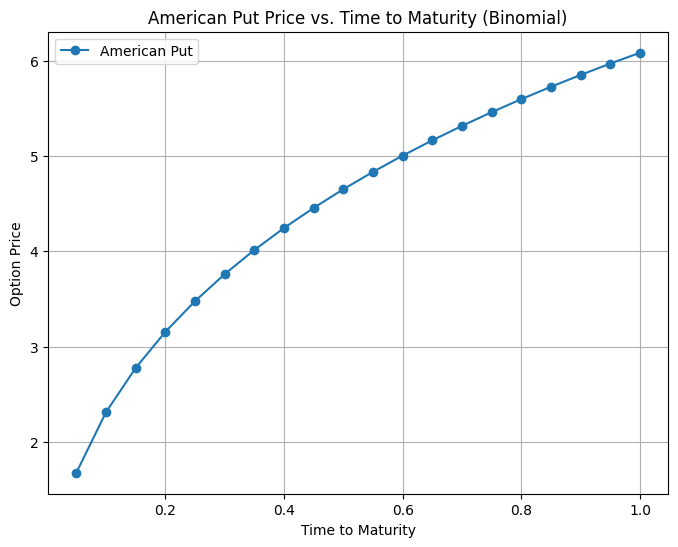

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def american_option_binomial(S0, K, r, sigma, T, N, option_type="put"):
    """
    Price an American option (call or put) using a binomial tree.

    Parameters:
        S0 : float
            Initial stock price.
        K : float
            Strike price.
        r : float
            Risk-free interest rate.
        sigma : float
            Volatility.
        T : float
            Time to maturity.
        N : int
            Number of time steps.
        option_type : str
            "put" or "call".

    Returns:
        float : Option price.
    """
    dt = T / N
    # Cox-Ross-Rubinstein factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize arrays for stock prices and option values at terminal nodes.
    stock_prices = np.zeros(N + 1)
    option_values = np.zeros(N + 1)

    # Stock prices at maturity
    for i in range(N + 1):
        stock_prices[i] = S0 * (u ** i) * (d ** (N - i))
        if option_type.lower() == "put":
            option_values[i] = max(K - stock_prices[i], 0)
        elif option_type.lower() == "call":
            option_values[i] = max(stock_prices[i] - K, 0)
        else:
            raise ValueError("option_type must be 'put' or 'call'.")

    # Backward induction: step backwards through the tree
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            stock_price = S0 * (u ** i) * (d ** (j - i))
            # Continuation value: expected option value discounted one step
            continuation = np.exp(-r * dt) * (p * option_values[i + 1] + (1 - p) * option_values[i])
            # Immediate exercise value
            if option_type.lower() == "put":
                exercise = max(K - stock_price, 0)
            else:  # call
                exercise = max(stock_price - K, 0)
            # American option: take the maximum (can exercise early)
            option_values[i] = max(continuation, exercise)

    return option_values[0]


def compute_greeks_binomial(S0, K, r, sigma, T, N, option_type="put", eps=0.01):
    """
    Compute option Greeks using finite differences with the binomial pricing method.

    Parameters:
        S0, K, r, sigma, T, N, option_type: as before.
        eps : float
            Small perturbation for finite differences.

    Returns:
        dict : Greeks (Price, Delta, Gamma, Theta, Vega, Rho).
    """
    # Base price
    V0 = american_option_binomial(S0, K, r, sigma, T, N, option_type)

    # Delta: derivative w.r.t. underlying S0
    V_up = american_option_binomial(S0 + eps, K, r, sigma, T, N, option_type)
    V_down = american_option_binomial(S0 - eps, K, r, sigma, T, N, option_type)
    delta = (V_up - V_down) / (2 * eps)

    # Gamma: second derivative w.r.t. S0
    gamma = (V_up - 2 * V0 + V_down) / (eps ** 2)

    # Theta: derivative w.r.t. time (T); note: as time decreases, option value decreases.
    T_small = max(T - eps, 1e-6)
    V_T = american_option_binomial(S0, K, r, sigma, T_small, N, option_type)
    theta = (V_T - V0) / (-eps)

    # Vega: derivative w.r.t. volatility sigma
    V_up_sigma = american_option_binomial(S0, K, r, sigma + eps, T, N, option_type)
    V_down_sigma = american_option_binomial(S0, K, r, sigma - eps, T, N, option_type)
    vega = (V_up_sigma - V_down_sigma) / (2 * eps)

    # Rho: derivative w.r.t. risk-free rate r
    V_up_r = american_option_binomial(S0, K, r + eps, sigma, T, N, option_type)
    V_down_r = american_option_binomial(S0, K, r - eps, sigma, T, N, option_type)
    rho = (V_up_r - V_down_r) / (2 * eps)

    return {
        "Price": V0,
        "Delta": delta,
        "Gamma": gamma,
        "Theta": theta,
        "Vega": vega,
        "Rho": rho
    }


def plot_price_vs_time_binomial(S0, K, r, sigma, T_max, N, option_type="put"):
    """
    Plot option price versus time to maturity using the binomial model.
    We vary T from a small value up to T_max and plot the corresponding price.

    Parameters:
        S0, K, r, sigma, option_type: as before.
        T_max : float
            Maximum time to maturity to plot.
        N : int
            Number of time steps (fixed dt for each maturity).
    """
    T_values = np.linspace(0.05, T_max, 20)  # Avoid T=0 to prevent division issues
    prices = []
    for T in T_values:
        price = american_option_binomial(S0, K, r, sigma, T, N, option_type)
        prices.append(price)

    plt.figure(figsize=(8, 6))
    plt.plot(T_values, prices, marker='o', linestyle='-', label=f"American {option_type.title()}")
    plt.xlabel("Time to Maturity")
    plt.ylabel("Option Price")
    plt.title(f"American {option_type.title()} Price vs. Time to Maturity (Binomial)")
    plt.grid(True)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # Parameters
    S0 = 100
    K = 100
    r = 0.05
    sigma = 0.2
    T = 1.0        # For Greeks and initial price calculation
    N = 200        # Number of steps in binomial tree

    # Choose option type: "put" or "call"
    option_type = "put"

    # 1. Compute option price and Greeks via Binomial Tree
    greeks = compute_greeks_binomial(S0, K, r, sigma, T, N, option_type, eps=0.01)
    print(f"American {option_type.title()} via Binomial Tree:")
    for greek, value in greeks.items():
        print(f"{greek}: {value:.4f}")

    # 2. Plot option price versus time to maturity
    T_max = 1.0  # maximum time to maturity for plot
    plot_price_vs_time_binomial(S0, K, r, sigma, T_max, N, option_type)


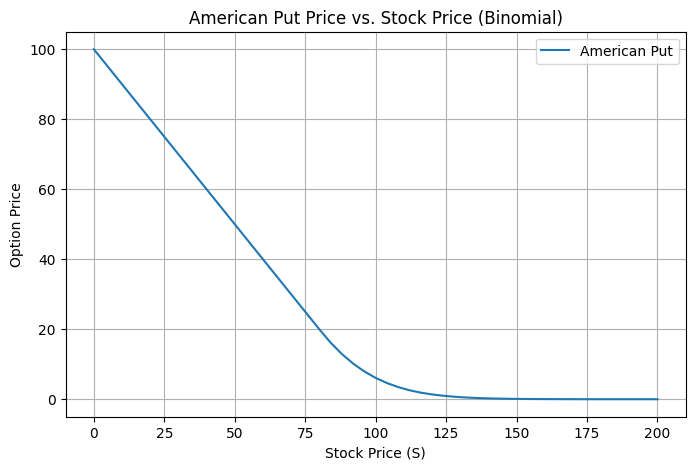

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_option_price_vs_stock_binomial(S_min, S_max, num_points,
                                       K, r, sigma, T, N,
                                       option_type="put"):
    """
    Plots the American option price (binomial) vs. stock price from S_min..S_max.
    """
    S_values = np.linspace(S_min, S_max, num_points)
    prices = []

    for S in S_values:
        price = american_option_binomial(S, K, r, sigma, T, N, option_type)
        prices.append(price)

    plt.figure(figsize=(8, 5))
    plt.plot(S_values, prices, label=f"American {option_type.title()}")
    plt.xlabel("Stock Price (S)")
    plt.ylabel("Option Price")
    plt.title(f"American {option_type.title()} Price vs. Stock Price (Binomial)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage after your existing code:
if __name__ == "__main__":
    # Existing parameters
    S0 = 100
    K = 100
    r = 0.05
    sigma = 0.2
    T = 1.0
    N = 200
    option_type = "put"

    # Plot from S=0 to S=200 in 51 points
    plot_option_price_vs_stock_binomial(
        S_min=0, S_max=200, num_points=51,
        K=K, r=r, sigma=sigma, T=T, N=N,
        option_type=option_type
    )
